In [1]:
import pandas as pd, numpy as np, seaborn as sns, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import f_oneway
import pingouin as pin
import matplotlib

from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option("display.precision", 2)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci, ABManalysis as af

#libraries for clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import os

import fastkde

### Preparing and cleaning the routes

### Coordinate System of the case study area for cartographic visualisations

In [2]:
print(os.getcwd())
city_name = 'UPB'
epsg = 4326
crs = 'EPSG:'+str(epsg)

C:\Users\RNGM\PedSimCity-EvaluationP2


# Questionnaire
## 1. Pre-processing

In [3]:
raw = pd.read_csv(r"C:\Users\RNGM\PedSimCity-EvaluationP2\Input\empiricalABM\UPB_responses_matrix_71.csv") # raw responses
raw['startdate'] = raw.apply(lambda row: row['startdate'][11:], axis = 1)
raw['datestamp'] = raw.apply(lambda row: row['datestamp'][11:], axis = 1)
raw['duration'] = raw.apply(lambda row: af.compute_duration(row['startdate'], row['datestamp']), axis = 1)    
raw['PD2'] = raw['PD2'].fillna(raw['PD2'].mean())
raw['age'] = raw['PD2'].astype(int)
print('Number of total participants:', str(len(raw)))

Number of total participants: 71


### 1.1 Disregard subjects who took less than n minutes to complete the study (Not yet needed.)

In [4]:
# cleaning
raw = raw[raw['duration']>= 1].copy()
print('Number of participants whose record was not disregarded ', str(len(raw)))
limit = {'A1':18, 'A2':25, 'A3':33, 'A4':41, 'A5':49, 'A6':57, 'A7':65, 'A8':73, 'A9':150}
# print("age issue", len(raw[~raw.FQ1.isnull()][['PD2', 'FQ1', 'limit']][raw.age > raw.limit]) + 
#       len(raw[~raw.FQ1.isnull()][['PD2', 'FQ1', 'limit']][raw.age < raw.limit-7]))

Number of participants whose record was not disregarded  68


In [5]:
raw.rename(columns={"PD1": "sex"}, inplace = True)
values = ['A1', 'A2', 'A3', 'A4']
new_values = ["male", "female", "non-binary", "prefer not to"]
for n, value in enumerate(values):
    raw['sex'].replace(value, new_values[n], inplace = True)

### 1.1 Disregarding subjects who always chose the same response when asked how to proceed along the route

In [6]:
def check(index):
    response = list(raw[to_check].loc[index][raw[to_check].loc[index].notna()])
    percentageA1 = response.count("A1")/len(response)
    percentageA2 = response.count("A2")/len(response)
    if ((percentageA1 > 0.65) | (percentageA2 > 0.65)) & (raw.loc[index].duration < 30):
        return True
    return False

# checking videos
video_columns = [col for col in raw if col.startswith('VD')]
to_remove = ['VD000a','VD000','VD001[SQ001]', 'VD002a', 'VD002', 'VD003[SQ001]','VD004a','VD004', 'VD005[SQ001]']
#to_check = [item for item in video_columns if item not in to_remove]
to_check = [item for item in video_columns]
raw['allSame'] = raw.apply(lambda row: check(row.name), axis = 1)

## 2. Demographic information

### 2.1 General information

In [7]:
nr = 'Number'
pr = 'participants'

N = len(raw)
print(nr+' of female '+pr +': '+str(len(raw[raw.sex == 'female']))+', '+str(round(len(raw[raw.sex == 'female'])/N*100,1))+'%')
print(nr+' of male '+pr +': '+str( len(raw[raw.sex == 'male']))+', '+str(round(len(raw[raw.sex == 'male'])/N*100,1))+'%')
print(nr+' of non-binary '+pr +': '+str(len(raw[raw.sex == 'non-binary']))+', '+str(round(len(raw[raw.sex == 'non-binary'])/N*100, 1))+'%')
print(nr+' of '+pr+' who preferred not to declare their gender: '+str(len(raw[raw.sex == 'prefer not to']))+', '+
      str(round(len(raw[raw.sex == 'prefer not to'])/N*100, 1))+'%')
print()
print("Particpants' mean age:", round(raw['age'].mean(),3))
print("Particpants' std age:", round(raw['age'].std(), 3))
print()
print('Mean duration:', str(round(raw.duration.mean(), 2))+" minutes")

Number of female participants: 28, 41.2%
Number of male participants: 35, 51.5%
Number of non-binary participants: 1, 1.5%
Number of participants who preferred not to declare their gender: 4, 5.9%

Particpants' mean age: 21.235
Particpants' std age: 1.594

Mean duration: 8.12 minutes


### 2.2 Age categories

In [8]:
Ga = len(raw[raw.age < 18])
Gb = len(raw[(raw.age >= 18) & (raw.age <= 25)])
Gc = len(raw[(raw.age >= 26) & (raw.age <= 33)])
Gd = len(raw[(raw.age >= 34) & (raw.age <= 41)])
Ge = len(raw[(raw.age >= 42) & (raw.age <= 49)])
Gf = len(raw[(raw.age >= 50) & (raw.age <= 57)])
Gg = len(raw[(raw.age >= 58) & (raw.age <= 65)])
Gh = len(raw[(raw.age >= 66) & (raw.age <= 73)])
Gi = len(raw[(raw.age >= 74)])

print("Number of participants per age group")
print()
print('< 18: '+str(Ga)+', '+str(round(Ga/N*100, 1))+ '%')
print('18 - 25: '+str(Gb)+', '+str(round(Gb/N*100, 1))+ '%')
print('26 - 33: '+str(Gc)+', '+str(round(Gc/N*100, 1))+ '%')
print('34 - 41: '+str(Gd)+', '+str(round(Gd/N*100, 1))+ '%')
print('42 - 49: '+str(Ge)+', '+str(round(Ge/N*100, 1))+ '%')
print('50 - 57: '+str(Gf)+', '+str(round(Gf/N*100, 1))+ '%')
print('58 - 65: '+str(Gg)+', '+str(round(Gg/N*100, 1))+ '%')
print('66 - 73: '+str(Gh)+', '+str(round(Gh/N*100, 1))+ '%')
print('> 74:'+str(Gi)+', '+str(round(Gi/N*100, 1))+ '%')

Number of participants per age group

< 18: 0, 0.0%
18 - 25: 67, 98.5%
26 - 33: 1, 1.5%
34 - 41: 0, 0.0%
42 - 49: 0, 0.0%
50 - 57: 0, 0.0%
58 - 65: 0, 0.0%
66 - 73: 0, 0.0%
> 74:0, 0.0%


### 2.3 Links or relationship to the case-study area (UPB)

In [9]:
Ga = len(raw[~raw['PD3[SQ001]'].isnull()])
Gb = len(raw[~raw['PD3[SQ002]'].isnull()])
Gc = len(raw[~raw['PD3[SQ003]'].isnull()])

nr = "Number of participants who "

print(nr+'Study in UPB: '+str(Ga)+', '+str(round(Ga/N*100,1))+ '%')
print(nr+'Work in UPB: '+str(Gb)+', '+str(round(Gb/N*100,1))+ '%')
print(nr+'Occasionally visit UPB: '+str(Gc)+', '+str(round(Gc/N*100,1))+ '%')

Number of participants who Study in UPB: 68, 100.0%
Number of participants who Work in UPB: 3, 4.4%
Number of participants who Occasionally visit UPB: 1, 1.5%


### 2.4 Reasons for walking

In [10]:
columns = ['WB2[SQ001]', 'WB2[SQ002]']
labels = ['Commuting to/from work', 'Commuting to/from university']

#'WB2[SQ003]','WB2[SQ004]','WB2[SQ005]'
#'For social activities', For exercise or free-time activities', 'For other daily errands and commitments'
          
for column in columns: 
    raw[column].replace('A1', 1, inplace = True)
    raw[column].replace('A2', 2, inplace = True)
    raw[column].replace('A3', 3, inplace = True)
    raw[column].replace('A4', 4, inplace = True)
    raw[column].replace('A5', 5, inplace = True)

total_prob = 0.0
for n, column in enumerate(columns):
    prob = round(raw[column].mean(),3)
    total_prob += prob
    print(labels[n]+':', str(round(raw[column].mean(),3))) # value on the Likert scale
    print("percentage: ", str(round(raw[column].mean()*100/5,3))+'%')
    if n < len(columns)-1: 
        print()

Commuting to/from work: 2.216
percentage:  44.314%

Commuting to/from university: 4.517
percentage:  90.345%


#### *Reasons for Walking: Transformation into probabilities*

In [11]:
for n, column in enumerate(columns):
    actual_prob = round(raw[column].mean()/total_prob,2)
    print(str(labels[n]) + ': '+str(actual_prob))

Commuting to/from work: 0.33
Commuting to/from university: 0.67


## 3. Familiriaty, spatial knowledge and preferences
### 3.1 Time spent living in the case-study area (*familiarity*) (SKIP)

In [12]:
#raw[['PD4[SQ001]', 'PD4[SQ002]']] = raw[['PD4[SQ001]', 'PD4[SQ002]']].fillna(0.0)
#raw['PD4[SQ002]'].replace(1984.0, 2021-1984, inplace = True)
#raw['familiarity'] = raw['PD4[SQ001]']/12 + raw['PD4[SQ002]']
#raw['familiarity'].plot.kde()

### 3.2 Self-reported spatial knowledge

0    0.000
1    0.000
2    0.000
3    4.500
4    4.250
      ... 
63   4.000
64   3.250
65   4.500
66   0.000
68   3.000
Name: knowledge, Length: 68, dtype: float64


<AxesSubplot: ylabel='Density'>

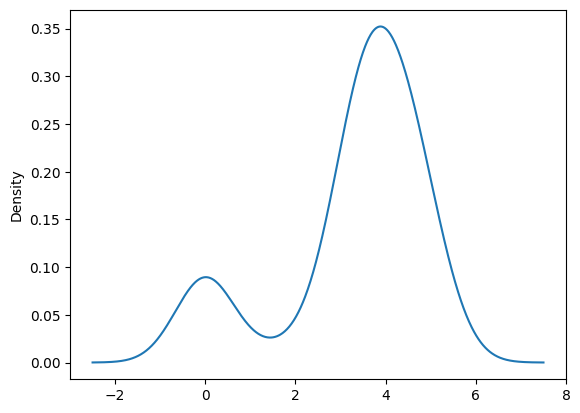

In [13]:
columns = ['WB4[SQ001]', 'WB4[SQ002]','WB4[SQ003]','WB4[SQ004]']
for column in columns: 
    raw[column].replace('A1', 1, inplace = True)
    raw[column].replace('A2', 2, inplace = True)
    raw[column].replace('A3', 3, inplace = True)
    raw[column].replace('A4', 4, inplace = True)
    raw[column].replace('A5', 5, inplace = True)
raw['knowledge'] = (raw['WB4[SQ001]'] + raw['WB4[SQ002]'] + raw['WB4[SQ003]'] +raw['WB4[SQ004]'])/4
raw['knowledge'] = raw['knowledge'].fillna(0.00)
print(raw['knowledge'])
raw['knowledge'].plot.kde()

In [14]:
columns = ['WB4[SQ001]', 'WB4[SQ002]','WB4[SQ003]','WB4[SQ004]', 'knowledge']
raw[columns].corr(method='pearson')

,WB4[SQ001],WB4[SQ002],WB4[SQ003],WB4[SQ004],knowledge
WB4[SQ001],1.000,0.658,0.088,0.173,0.491
WB4[SQ002],0.658,1.000,0.293,0.353,0.826
WB4[SQ003],0.088,0.293,1.000,0.548,0.286
WB4[SQ004],0.173,0.353,0.548,1.000,0.604
knowledge,0.491,0.826,0.286,0.604,1.000


### 3.3 Preference for and aversion to barriers (SKIP)

In [15]:
columns = ['SP4[SQ004]', 'SP4[SQ005]','SP4[SQ007]']
for column in columns: 
    raw[column].replace('A1', 0.00, inplace = True)
    raw[column].replace('A2', 0.25, inplace = True)
    raw[column].replace('A3', 0.50, inplace = True)
    raw[column].replace('A4', 0.75, inplace = True)
    raw[column].replace('A5', 1.00, inplace = True)

raw['preferenceNatural'] = raw['SP4[SQ004]'] ## preference for Natural Barriers
raw['preferenceNatural'] = raw['preferenceNatural'].fillna(0.00)
raw['aversionSevering'] = (raw['SP4[SQ005]'] + raw['SP4[SQ007]'])/2 ## Aversion to Severing Barriers
raw['aversionSevering'] = raw['aversionSevering'].fillna(0.00)

## 4. Video Tasks: route choice behaviour variables
#### *Preliminary columns cleaning*

In [16]:
video_columns = [col for col in raw if col.startswith('VD')]
to_remove = ['VD000a', 'VD100a','VD200a']

columns = ['id'] + video_columns
columns = [item for item in columns if item not in to_remove] # remove not necessary video columns
responses = raw[columns].copy() # only response to the video taks

In [17]:
# cleaning and rename columns and prepare a legible dataframe 
for column in responses.columns:
    if column == 'id':
        continue
    responses.rename({column: column[2:]}, axis=1, inplace = True)
    
for column in responses.columns:
    if column == 'id':
        continue
    if ('a' in column) | ('b' in column): 
        continue
    new_column = '-'.join(column[i:i+3] for i in range(0, len(column), 3))
    responses.rename({column: new_column}, axis=1, inplace = True)


#### *Loading the routes used in the survey* 

In [18]:
survey_routes = gpd.read_file("Outputs/Routes_sections.shp").to_crs(crs)
summary = pd.DataFrame(columns = ['id']+list(survey_routes.video.unique()))

summary = summary.reindex(sorted(summary.columns), axis=1)

for row in responses.itertuples():
    sectors = responses.loc[row.Index].notna().dot(responses.columns+',').rstrip(',')
    sectors = sectors.replace('-', ',')
    sectors_list = sectors.strip('').split(',')
    for sector in sectors_list:
        summary.at[row.Index, sector] = 1
        summary.at[row.Index, 'id'] = responses.loc[row.Index].id
        
summary.fillna(0, inplace = True)
for column in summary.columns: 
    summary.rename(columns={column: str(column)}, inplace = True)

In [19]:
summary.head(69)

,000,001,002,100,101,102,200,201,202,id
0,1,1,0,1,1,0,1,1,0,1
1,1,1,0,1,1,0,1,1,0,2
2,1,1,0,1,1,0,1,1,0,3
3,1,0,0,1,0,0,1,1,1,4
4,1,1,1,1,1,0,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...
63,1,1,0,1,1,0,1,1,0,64
64,1,1,0,1,1,0,1,1,0,65
65,1,1,0,1,1,0,1,1,0,66
66,1,1,0,1,1,0,1,1,0,67


### 4.1 Obtaining the general statistics

In [20]:
survey_routes['routeChoice'] = survey_routes.apply(lambda row: row['routeChoic'].replace(" ",""), axis = 1)
survey_routes['routeChoice'] = survey_routes.apply(lambda row: row['routeChoice'].strip('][').split(','), axis = 1)
survey_routes.drop('routeChoic', inplace = True, axis = 1)

#### *Computing for each subject how much they resorted to certain urban elements or road costs*

In [21]:
route_variables = ['usingElements','noElements', 'distanceHeuristic', 'routeMarks', 'barriers', 'preferenceNatural', 'aversionSevering']
other_variables = ["length", "minimisation_length", "combined_length"]

#'usingElements','noElements', 'onlyAngular', 'distanceHeuristic', 'angularHeuristic', 'regions', 'barriers','distantLandmarks', 'preferenceNatural', 'aversionSevering'
# "minimisation_length","combined_length"
video0 = [col for col in summary if col.startswith('0')]
video1 = [col for col in summary if col.startswith('1')]
video2 = [col for col in summary if col.startswith('2')]
videos = [video0, video1, video2]
routes_stats = af.set_routes_stats(summary, survey_routes, videos)

In [22]:
## appending variables regarding the preference for natural/severing barriers and spatial knowledge

raw.index = raw['id']
routes_stats.index.name = None
routes_stats['preferenceNatural'] = raw['preferenceNatural']
routes_stats['aversionSevering'] = raw['aversionSevering']
routes_stats['knowledge'] = raw['knowledge']
routes_stats.head(70)

,onlyDistance,onlyAngular,distanceHeuristic,angularHeuristic,regions,routeMarks,barriers,distantLandmarks,usingElements,noElements,length,combined_length,minimisation_length,preferenceNatural,aversionSevering,knowledge
1,1.000,0.000,0.762,0.238,0.000,0.168,0.832,0.000,0.500,0.500,0.007,791.585,791.585,0.000,0.000,0.000
2,1.000,0.000,0.762,0.238,0.000,0.168,0.832,0.000,0.500,0.500,0.007,791.585,791.585,0.000,0.000,0.000
3,1.000,0.000,0.762,0.238,0.000,0.168,0.832,0.000,0.500,0.500,0.007,791.585,791.585,0.000,0.000,0.000
4,1.000,0.000,0.539,0.461,0.000,0.437,0.563,0.000,0.559,0.441,0.007,805.879,469.146,2.000,4.500,4.500
5,1.000,0.000,0.673,0.327,0.000,0.265,0.735,0.000,0.603,0.397,0.011,1246.210,791.585,5.000,4.500,4.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,1.000,0.000,0.762,0.238,0.000,0.168,0.832,0.000,0.500,0.500,0.007,791.585,791.585,4.000,3.500,4.000
65,1.000,0.000,0.762,0.238,0.000,0.168,0.832,0.000,0.500,0.500,0.007,791.585,791.585,5.000,4.500,3.250
66,1.000,0.000,0.762,0.238,0.000,0.168,0.832,0.000,0.500,0.500,0.007,791.585,791.585,4.000,4.500,4.500
67,1.000,0.000,0.762,0.238,0.000,0.168,0.832,0.000,0.500,0.500,0.007,791.585,791.585,0.000,0.000,0.000


#### *Obtaining the input matrix for cluster analysis*

In [23]:
input_matrix = routes_stats[route_variables].copy()
input_matrix.replace(0.0, 0.01, inplace = True)
cluster_variables =  ['distanceHeuristic', 'routeMarks', 'barriers']
#'onlyDistance', 'onlyAngular', 'distanceHeuristic', 'angularHeuristic', 'regions', 'routeMarks', 'barriers','distantLandmarks'

for column in cluster_variables:
    if column in ['onlyDistance', 'onlyAngular']:
        input_matrix[column] = input_matrix[column] * input_matrix['noElements'] 
    else:
        input_matrix[column] = input_matrix[column] * input_matrix['usingElements']
input_matrix = input_matrix.astype(float)

print(input_matrix)

    usingElements  noElements  distanceHeuristic  routeMarks  barriers  \
1           0.500       0.500              0.381       0.084     0.416   
2           0.500       0.500              0.381       0.084     0.416   
3           0.500       0.500              0.381       0.084     0.416   
4           0.559       0.441              0.301       0.244     0.315   
5           0.603       0.397              0.406       0.160     0.443   
..            ...         ...                ...         ...       ...   
64          0.500       0.500              0.381       0.084     0.416   
65          0.500       0.500              0.381       0.084     0.416   
66          0.500       0.500              0.381       0.084     0.416   
67          0.500       0.500              0.381       0.084     0.416   
69          0.603       0.397              0.406       0.160     0.443   

    preferenceNatural  aversionSevering  
1               0.010             0.010  
2               0.010      

### 4.2 Visualising overall importance of each urban element (probabilities)

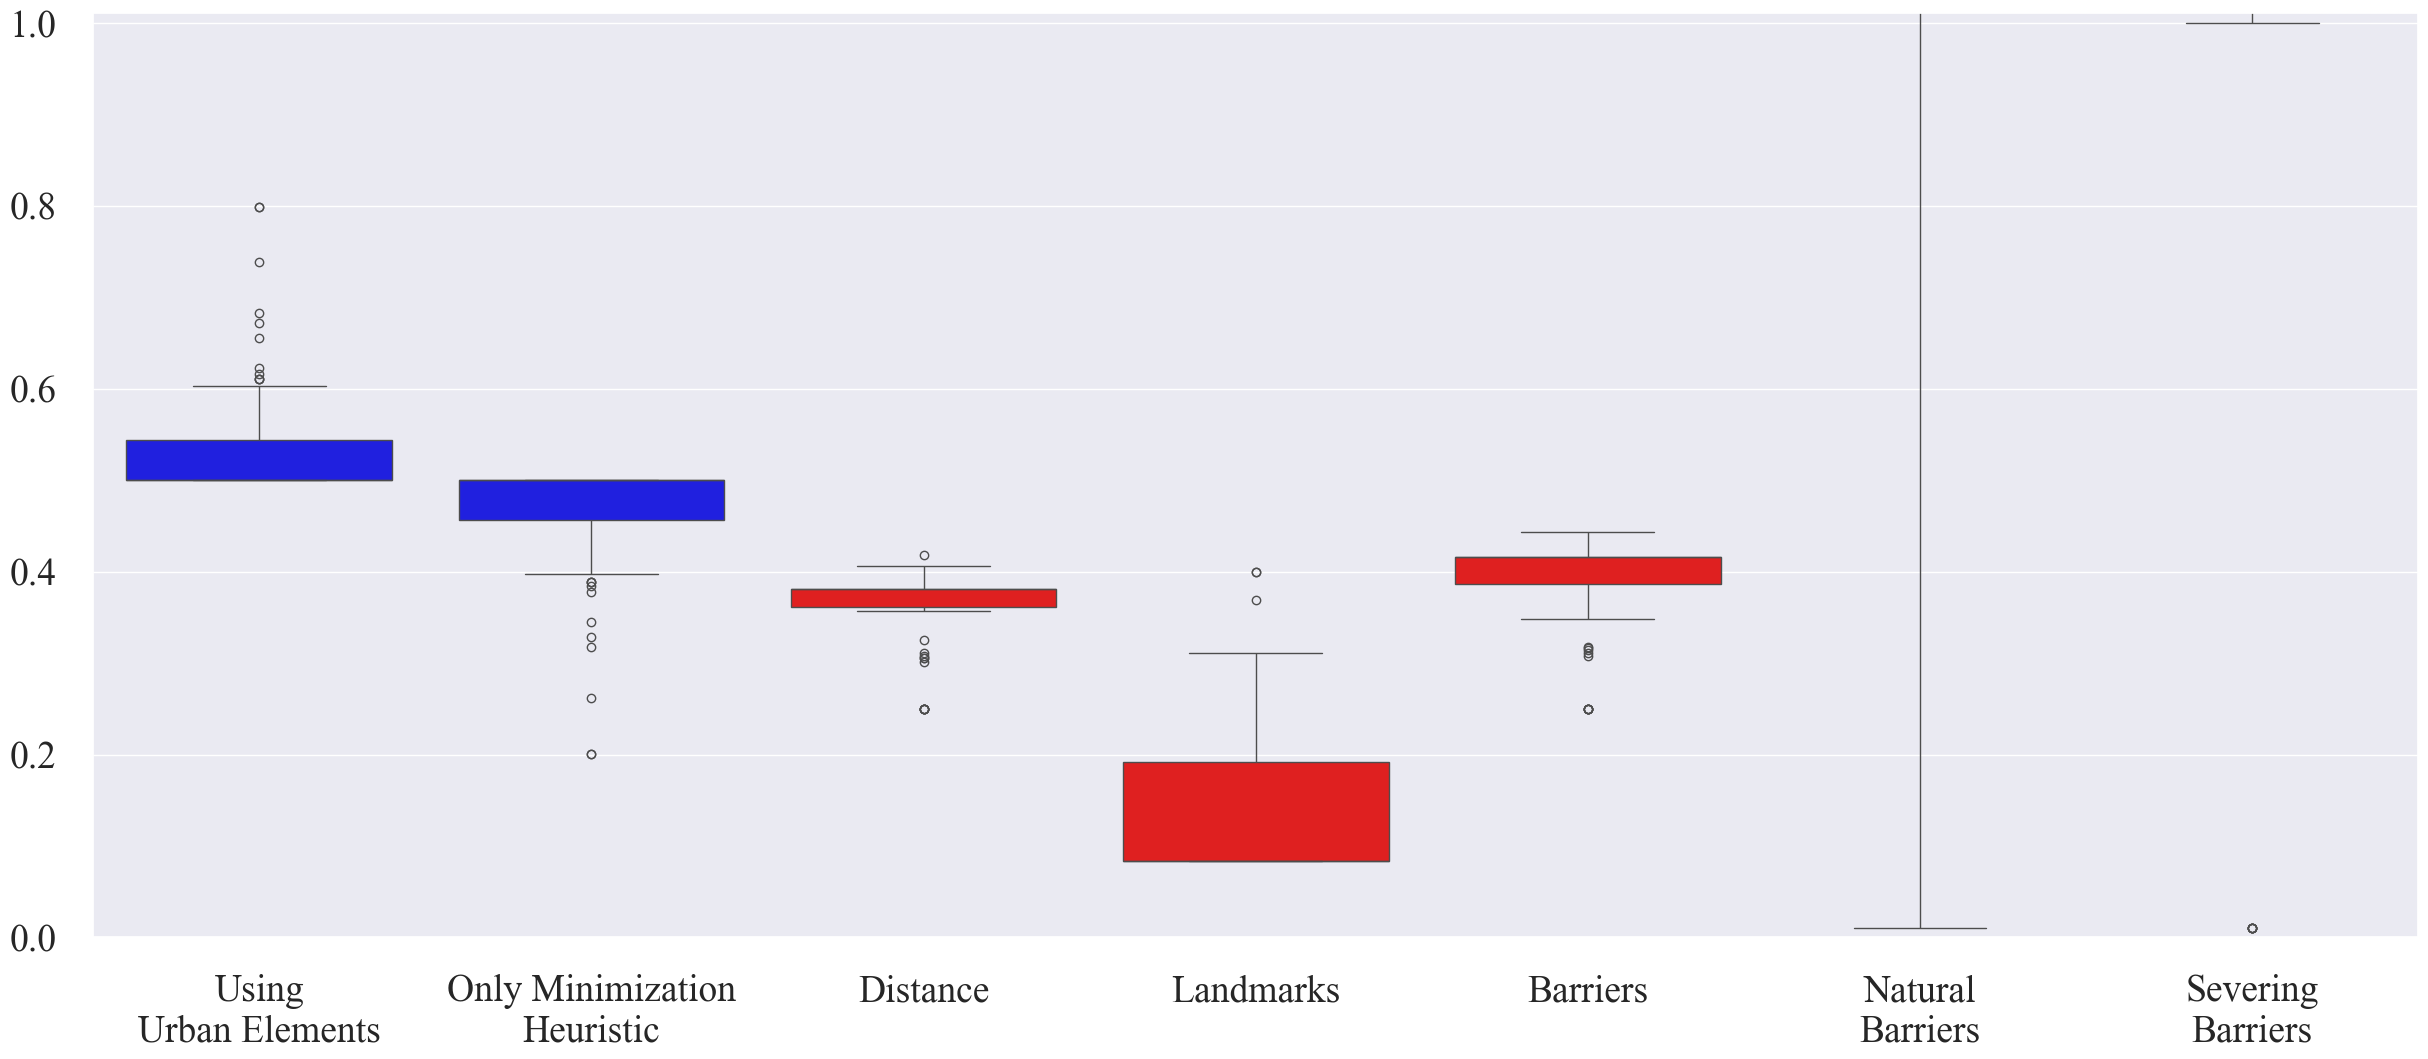

In [24]:
sns.set()
sns.set_color_codes()
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(30, 12)) 

## obtaining dataframe for boxplot visualisation
tab = pd.DataFrame(columns = ['variable', 'value']) 
labels = ['Using\nUrban Elements', 'Only Minimization\nHeuristic', 'Distance', 'Landmarks', 'Barriers', 
          'Natural\nBarriers', 'Severing\nBarriers']

index = 0
for subject in input_matrix.index:
    for n, variable in enumerate(route_variables):
        tab.at[index, 'variable'] = labels[n]
        tab.at[index, 'value'] = input_matrix.loc[subject][variable]
        index += 1

palette = ['blue']*2 + ['red']*8 + ['lime']*2
ax = sns.boxplot(x="variable", y="value", data=tab, palette = palette)
ax.set_ylim(0.0, 1.01)
ax.set_ylabel('', fontsize = 27, labelpad = 30, fontfamily = 'Times New Roman')
ax.set_xlabel('', labelpad = 30, fontfamily = 'Times New Roman')

for tick in ax.get_yticklabels(): 
    tick.set_fontname('Times New Roman')
for tick in ax.get_xticklabels(): 
    tick.set_fontname('Times New Roman')
    
ax.tick_params(axis='both', labelsize= 27, pad = 20)

In [25]:
fig.savefig("Outputs/Figures/empiricalABM/f4test_69responses.pdf", bbox_inches='tight')

In [26]:
print(cluster_variables)
input_matrix[cluster_variables].mean()
input_matrix[cluster_variables]

['distanceHeuristic', 'routeMarks', 'barriers']


,distanceHeuristic,routeMarks,barriers
1,0.381,0.084,0.416
2,0.381,0.084,0.416
3,0.381,0.084,0.416
4,0.301,0.244,0.315
5,0.406,0.160,0.443
...,...,...,...
64,0.381,0.084,0.416
65,0.381,0.084,0.416
66,0.381,0.084,0.416
67,0.381,0.084,0.416


In [27]:
input_matrix[cluster_variables].corr(method='pearson')

,distanceHeuristic,routeMarks,barriers
distanceHeuristic,1.000,-0.449,0.986
routeMarks,-0.449,1.000,-0.562
barriers,0.986,-0.562,1.000


## 5. Cluster Analysis
### 5.1 Variables transformation

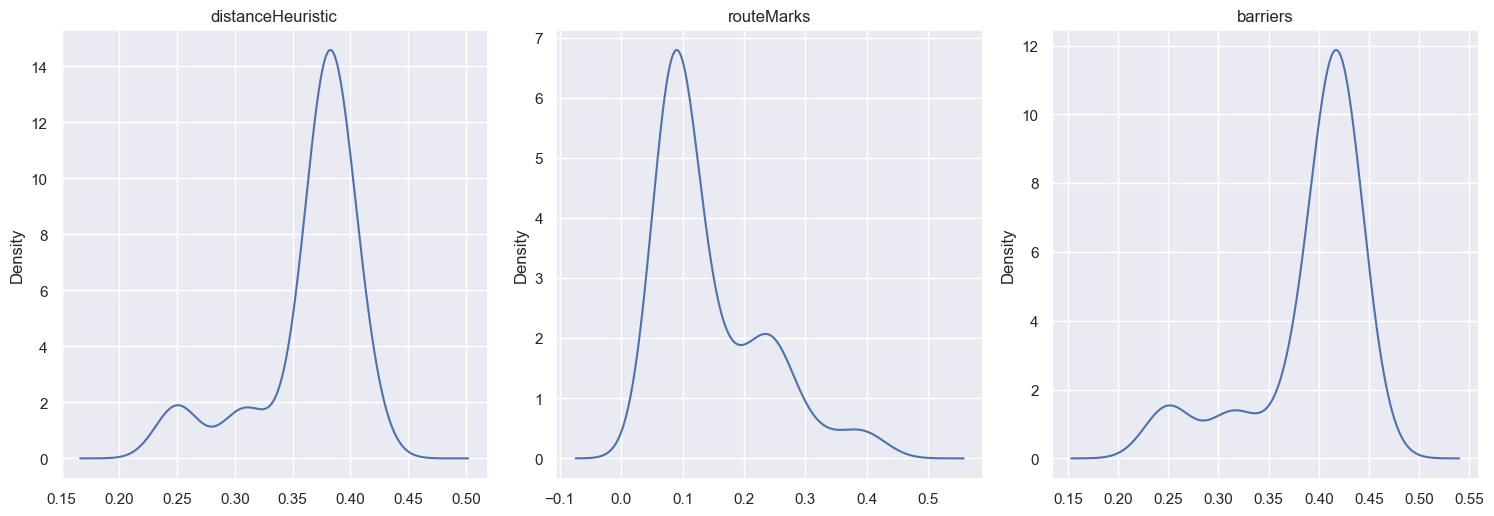

In [28]:
#X = input_matrix[cluster_variables].copy()
#fig = plt.figure(figsize = (20, 10))
#for n, column in enumerate(list(X.columns)):
#    ax = fig.add_subplot(2,4,n+1)
#    ax = X[column].plot.kde()
#    ax.set_title(column)


# Assuming input_matrix is a DataFrame and cluster_variables is a list of columns to plot
X = input_matrix[cluster_variables].copy()

if len(X) > 0 and X.shape[1] > 1:
    fig = plt.figure(figsize=(20, 10))
    for n, column in enumerate(list(X.columns)):
        if len(X[column]) > 1 and len(X[column].unique()) > 1:
            ax = fig.add_subplot(2, 4, n + 1)
            ax = X[column].plot(kind='kde', ax=ax)
            ax.set_title(column)

plt.tight_layout()
plt.show()

#### *Logarithmic transformation and standardisation*

In [29]:
X_log = af.log_transf(input_matrix[cluster_variables])
X_log_stand = X_log.copy()
    
for column in X_log.columns:
    try:
        X_log_stand[column] = af.standardise_column(X_log, column)
    except ValueError as e:
        print(f"Error standardizing column {column}: {e}. Skipping...")

### 5.2 Obtaining and comparing different clustered structures obtained with the k-means algorithm

In [30]:
list_scores = []

def pipe_kmeans(X_toFit):

    X_tmp = X_toFit.copy()
    for n_clusters in range(2, 8):
        clusterer = KMeans(n_clusters = n_clusters, n_init = 2000).fit(X_toFit)
        labels = clusterer.labels_

        score = round(silhouette_score(X_tmp, labels, metric= 'sqeuclidean'), 3)
        param_score = {'algorithm': 'k-means', 'n_clusters' : n_clusters, 'score' : score,
                       'clusterer' : clusterer}
        list_scores.append(param_score)

pipe_kmeans(X_log_stand)
clustering = pd.DataFrame(list_scores)
clustering.sort_values(by = 'score', ascending = False)

,algorithm,n_clusters,score,clusterer
0,k-means,2,0.858,"KMeans(n_clusters=2, n_init=2000)"
5,k-means,7,0.847,"KMeans(n_clusters=7, n_init=2000)"
2,k-means,4,0.841,"KMeans(n_clusters=4, n_init=2000)"
4,k-means,6,0.834,"KMeans(n_clusters=6, n_init=2000)"
3,k-means,5,0.828,"KMeans(n_clusters=5, n_init=2000)"
1,k-means,3,0.800,"KMeans(n_clusters=3, n_init=2000)"


In [31]:
#def pipe_kmeans_VCR(X):

#    VRCs = []
#    X_tmp = X.copy()
#    X_toFit = X.copy()
    
#    for n_clusters in range(2, 11):
        
#        clusterer = KMeans(n_clusters = n_clusters, n_init = 2000).fit(X_toFit)
#        X_tmp['cluster'] = clusterer.labels_

#        f = 0.0
#        for var in cluster_variables:
#            arrays = []
#            for cluster in list(X_tmp['cluster'].unique()):
#                arrays.append(X_tmp[var+'_log'][X_tmp.cluster == cluster])
            
#            if n_clusters == 2:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1])).statistic
#            if n_clusters == 3:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2])).statistic
#            if n_clusters == 4:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), 
#                                     np.array(arrays[3])).statistic
#            if n_clusters == 5:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
#                          np.array(arrays[4])).statistic
#            if n_clusters == 6:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
#                          np.array(arrays[4]),np.array(arrays[5])).statistic
#            if n_clusters == 7:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
#                          np.array(arrays[4]),np.array(arrays[5]),np.array(arrays[6])).statistic
#            if n_clusters == 8:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
#                          np.array(arrays[4]), np.array(arrays[5]), np.array(arrays[6]), np.array(arrays[7])).statistic
#            if n_clusters == 9:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
#                          np.array(arrays[4]),np.array(arrays[5]), np.array(arrays[6]), np.array(arrays[7]), np.array(arrays[8])
#                                    ).statistic
#            if n_clusters == 10:
#                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
#                          np.array(arrays[4]), np.array(arrays[5]), np.array(arrays[6]), np.array(arrays[7]), 
#                                     np.array(arrays[8]), np.array(arrays[9])).statistic
            
#            f += statistic
#        VRCs.append(f)   
#    return VRCs

#VRCs = pipe_kmeans_VCR(X_log_stand)

def pipe_kmeans_VCR(X):

    VRCs = []
    X_tmp = X.copy()
    X_toFit = X.copy()
    
    for n_clusters in range(2, 9):
        
        clusterer = KMeans(n_clusters = n_clusters, n_init = 2000).fit(X_toFit)
        X_tmp['cluster'] = clusterer.labels_

        f = 0.0
        for var in cluster_variables:
            arrays = []
            for cluster in list(X_tmp['cluster'].unique()):
                arrays.append(X_tmp[var+'_log'][X_tmp.cluster == cluster])
            
            if n_clusters == 2:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1])).statistic
            if n_clusters == 3:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2])).statistic
            if n_clusters == 4:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), 
                                     np.array(arrays[3])).statistic
            if n_clusters == 5:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4])).statistic
            if n_clusters == 6:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5])).statistic
            if n_clusters == 7:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5]),np.array(arrays[6])).statistic
            if n_clusters == 8:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]), np.array(arrays[5]), np.array(arrays[6]), np.array(arrays[7])).statistic
            f += statistic
        VRCs.append(f)   
    return VRCs

VRCs = pipe_kmeans_VCR(X_log_stand)

### 5.3 Choosing the best structure

In [32]:
print("Clusters\tOmega\t\t\tVRC")
for n, VRC in enumerate(VRCs):
    if (n == 0) | (n == len(VRCs)-1):
        continue
    index = (VRCs[n+1]-VRC)-(VRC-VRCs[n-1])
    print(f"{n+2}\t\t{round(index, 3)}\t\t\t{round(VRC, 3)}")

Clusters	Omega			VRC
3		551.258			549.06
4		-218.834			896.749
5		257.002			1025.605
6		-576.562			1411.464
7		785.316			1220.76


In [33]:
chosen = clustering.loc[1]
labels_cluster = np.array(chosen.clusterer.labels_.copy())
labels_cluster += 1

In [34]:
input_with_cluster = input_matrix.copy()
input_with_cluster['cluster'] = labels_cluster

### 5.4 Examining the chosen partition

In [35]:
input_with_cluster['knowledge'] = raw['knowledge']
cluster_stats = input_with_cluster.groupby("cluster").mean()
cluster_stats

,usingElements,noElements,distanceHeuristic,routeMarks,barriers,preferenceNatural,aversionSevering,knowledge
cluster,,,,,,,,
1,0.652,0.348,0.385,0.241,0.411,3.385,3.155,3.346
2,0.527,0.473,0.276,0.248,0.279,3.274,3.137,3.045
3,0.505,0.495,0.382,0.090,0.415,3.728,3.524,3.375


         usingElements  noElements  distanceHeuristic  routeMarks  barriers  \
cluster                                                                       
1                0.652       0.348              0.385       0.241     0.411   
2                0.527       0.473              0.276       0.248     0.279   
3                0.505       0.495              0.382       0.090     0.415   

         preferenceNatural  aversionSevering  knowledge  
cluster                                                  
1                    3.385             3.155      3.346  
2                    3.274             3.137      3.045  
3                    3.728             3.524      3.375  


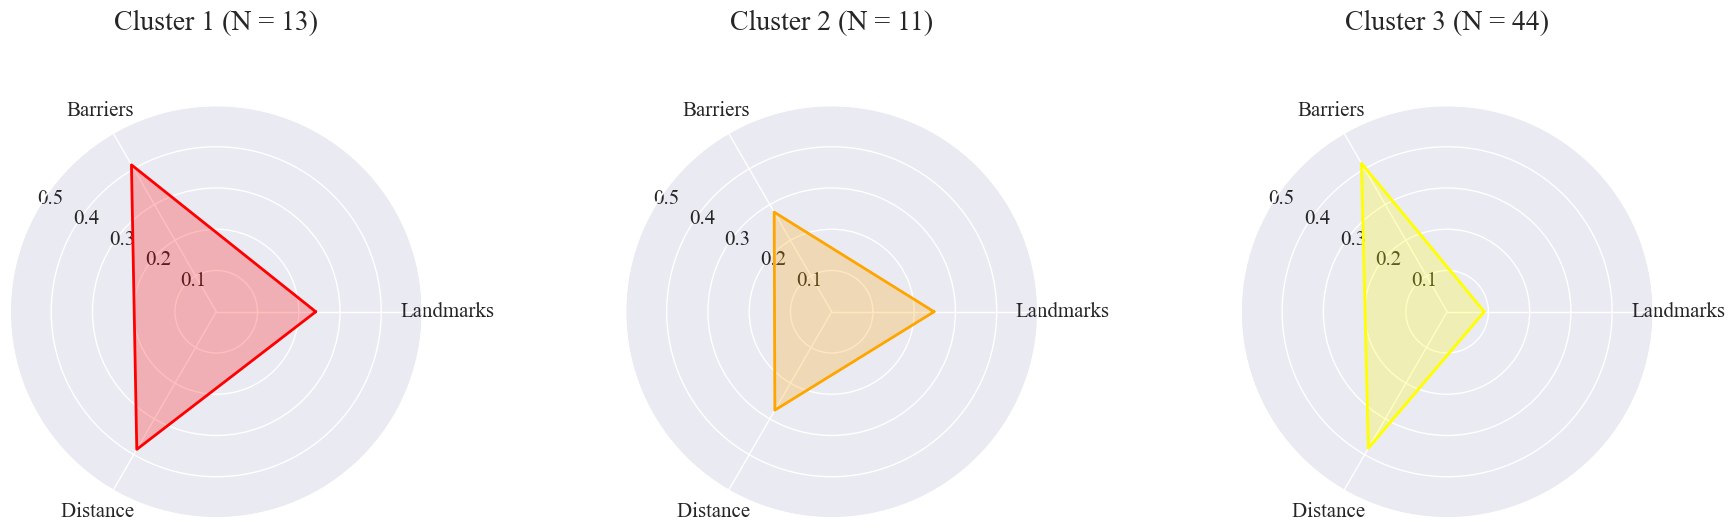

In [36]:
sns.set()
sns.set_color_codes()

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'pink',
         'c', 'black']

clusters_stats = input_with_cluster.groupby(by = 'cluster').mean()
figsize = (22.5, (15/2*3))
fig = plt.figure(figsize = figsize)
plot_variables = ['routeMarks', 'barriers', 'distanceHeuristic']
cluster_v = np.array(plot_variables)
labels = ['Landmarks','Barriers','Distance '] 
plt.rcParams['font.family'] = 'Times New Roman'
to_plot = list(clusters_stats.index)

for cluster in to_plot:

    if cluster != 'population':
        tmp = clusters_stats.loc[cluster, cluster_v].values

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    
    # close the plot
    tmp = np.concatenate((tmp,[tmp[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    
    if cluster != 'population':
        ax = fig.add_subplot(3, 3, cluster, polar = True)
        color = colors[cluster-1]
    
    ax.plot(angles, tmp, '-', color = color, linewidth=2)
    ax.fill(angles, tmp, color = color, alpha=0.25)
    ax.set_thetagrids((angles * 180/np.pi)[0:len(plot_variables)], labels, fontsize = 15)
    ax.yaxis.set_ticks([0.10, 0.20, 0.30, 0.40, 0.50])
    ax.tick_params(axis='y', labelsize= 15)
    ax.tick_params(axis='x', labelsize= 15, pad = 5)
    ax.set_rlabel_position(150)
    
    if cluster != 'population':
        nr = len(input_with_cluster[input_with_cluster.cluster == cluster])
        title = "Cluster "+str(cluster) + " (N = "+str(nr)+")"      
    ax.set_title(title, va = 'bottom', fontsize = 20, pad = 50, fontfamily = 'Times New Roman')

fig.subplots_adjust(wspace=0.20, hspace = 0.60)

print(clusters_stats)

In [37]:
fig.savefig("Outputs/Figures/empiricalABM/f5_69.pdf", bbox_inches='tight')

#### *Spatial skills - Do they explain the variation in the route choice behaviour variables?*

In [38]:
clusters = list(set(labels_cluster))
for cluster in clusters:
    knowledge = input_with_cluster[input_with_cluster.cluster == cluster]['knowledge']
    print("cluster", cluster, "spatial skills/knowledge mean:", round(knowledge.mean(), 3), "std:", round(knowledge.std(), 3))

cluster 1 spatial skills/knowledge mean: 3.346 std: 1.763
cluster 2 spatial skills/knowledge mean: 3.045 std: 1.588
cluster 3 spatial skills/knowledge mean: 3.375 std: 1.485


In [39]:
tab = pd.DataFrame(columns=['cluster', 'variable', 'value']) 
labels = ['Distance', 'Landmarks', 'Barriers', 'Knowledge']

index = 0
for subject in input_with_cluster.index:
    for n, variable in enumerate(cluster_variables + ['knowledge']):
        if n < len(labels):
            tab.at[index, 'variable'] = labels[n]
        else:
            tab.at[index, 'variable'] = 'Unknown'
        tab.at[index, 'cluster'] = "Cluster " + str(int(input_with_cluster.loc[subject]['cluster']))
        tab.at[index, 'value'] = input_with_cluster.loc[subject][variable]
        index += 1

tab['value'] = tab.value.astype(float)
tab.sort_values('cluster', inplace=True)

In [40]:
# Check if the value column has at least two unique values for the knowledge variable
if len(tab[tab.variable == 'knowledge']['value'].unique()) < 2:
    print("The value column does not have at least two unique values for the knowledge variable.")
else:
    # Perform the t-test
    pin.pairwise_ttests(data=tab[tab.variable == 'knowledge'], dv='value', between='cluster')

The value column does not have at least two unique values for the knowledge variable.


#### *Demographic characteristics*

In [41]:
raw['cluster'] = labels_cluster
print('Age')
cluster_deom_stats = raw.groupby("cluster")['age'].mean()
print(cluster_deom_stats)

Age
cluster
1   21.077
2   20.818
3   21.386
Name: age, dtype: float64


In [42]:
print('Gender')
cluster_deom_stats = raw.groupby(["cluster", 'sex'])['sex'].count()
for cluster in range(1, max(labels_cluster)+1):
    print("cluster", cluster)
    for gender in list(cluster_deom_stats.loc[cluster].index):
        print(gender, round(cluster_deom_stats.loc[cluster][gender]/cluster_deom_stats.loc[cluster].sum() *100, 1))
    print()

Gender
cluster 1
female 38.5
male 61.5

cluster 2
female 63.6
male 27.3
prefer not to 9.1

cluster 3
female 36.4
male 54.5
non-binary 2.3
prefer not to 6.8



## 6. Final input data for building agent typologies in the ABM

In [43]:
columns = []
for column in input_with_cluster.columns:
    if column in ['knowledge', 'cluster']:
        continue
    columns.append(column+"_mean")
    columns.append(column+"_std")
    
groups = ['GROUP'+str(cluster) for cluster in input_with_cluster['cluster'].unique()]
indexes = groups + ['POPULATION', 'NULLGROUP']
clusters_gdf = pd.DataFrame(index = indexes, columns = columns)
variables = route_variables


clusters = input_with_cluster['cluster'].unique()
for index in indexes:
    for variable in variables:
        if index not in ['POPULATION', 'NULLGROUP']:
            cluster = int(index[5:])
            clusters_gdf.at[index, variable+'_mean'] = input_with_cluster[input_with_cluster.cluster == cluster][variable].mean()
            clusters_gdf.at[index, variable+'_std'] = input_with_cluster[input_with_cluster.cluster == cluster][variable].std()
        else:
            clusters_gdf.at[index, variable+'_mean'] = input_with_cluster[variable].mean()
            clusters_gdf.at[index, variable+'_std'] = input_with_cluster[variable].std()
    
    if index not in ['POPULATION', 'NULLGROUP']:
        cluster = int(index[5:])
        clusters_gdf.at[index, 'portion'] = len(input_with_cluster[input_with_cluster.cluster == cluster])/len(input_with_cluster)
    else:
        clusters_gdf.at[index, 'portion'] = 1.00

In [44]:
clusters_gdf

,usingElements_mean,usingElements_std,noElements_mean,noElements_std,distanceHeuristic_mean,distanceHeuristic_std,routeMarks_mean,routeMarks_std,barriers_mean,barriers_std,preferenceNatural_mean,preferenceNatural_std,aversionSevering_mean,aversionSevering_std,portion
GROUP3,0.505,0.015,0.495,0.015,0.382,0.010,0.090,0.013,0.415,0.012,3.728,1.385,3.524,1.357,0.647
GROUP2,0.527,0.049,0.473,0.049,0.276,0.029,0.248,0.040,0.279,0.033,3.274,1.616,3.137,1.396,0.162
GROUP1,0.652,0.086,0.348,0.086,0.385,0.026,0.241,0.091,0.411,0.031,3.385,1.500,3.155,1.212,0.191
POPULATION,0.537,0.071,0.463,0.071,0.365,0.044,0.145,0.086,0.392,0.054,3.589,1.435,3.391,1.330,1.000
NULLGROUP,0.537,0.071,0.463,0.071,0.365,0.044,0.145,0.086,0.392,0.054,3.589,1.435,3.391,1.330,1.000


In [45]:
## exporting the files 
clusters_gdf.to_csv('Outputs/empiricalABM/clusters_71.csv') ## this is imported into the ABM
routes_stats.to_csv('Outputs/empiricalABM/routes_stats_71.csv')